In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_device('cpu')

import numpy as np

from transformers_simple.transformer import MultiHeadAttention
from transformers_simple.train import Trainer
from transformers_simple.dataset import CharDataset

In [2]:
N = 4

block_size  = 2
embed_size  = 6
hidden_size = 30
num_heads = 3

vocab_size  = 3
input_size = embed_size
output_size = 20

log_interval = 50
epochs = 5
learning_rate = 2e-4
device = torch.device('cpu')

In [3]:
# #block size 1
# data = "".join(["abca"]*1000)

In [4]:
# block size 2
data = "".join(["aabcacb"]*1000)

In [5]:
dataset = CharDataset(data=data, block_size=block_size)
dataset[0]

(tensor([0, 0]), tensor([0, 1]))

In [6]:
class AdapterNet(torch.nn.Module):
    def __init__(self, net):
        super(AdapterNet,self).__init__()
        self.net = net
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.fc = torch.nn.Linear(output_size, vocab_size)
        self.act = torch.nn.LeakyReLU(0.05)
        
    def forward(self, x):
        nb, l = x.size()

        o = self.embedding(x)
        
        o = self.net(o)

        o = self.act(o)
        
        o = self.fc(o)
        
        return o
    
net = MultiHeadAttention(input_size=input_size,
                         output_size=output_size, 
                          hidden_size=hidden_size, 
                         num_heads=num_heads,
                         block_size=block_size,
                        attn_dropout=0.1,
                         residual_dropout=0.1)

model = AdapterNet(net)

In [7]:
x = dataset[0][0].view(1,-1)
y = dataset[0][1]

In [8]:
print(y)
print(y.size())

tensor([0, 1])
torch.Size([2])


In [9]:
o = model(x)
o.size()

torch.Size([1, 2, 3])

In [10]:
loss = torch.nn.CrossEntropyLoss()

def loss_fn(o,y):
    #return loss(o.view(-1,vocab_size),y.view(-1))
    return loss(o[:,-1],y[:,-1])

In [11]:
trainer = Trainer(model=model, 
                  dataset=dataset, 
                  loss_fn=loss_fn, 
                  batch_size=N, 
                  learning_rate=learning_rate,
                  epochs=epochs, 
                  log_interval=log_interval, 
                  device=device)

In [12]:
trainer.run()

Train Epoch: 0 [0/6998 (0%)]	Loss: 1.132577
Train Epoch: 0 [200/6998 (3%)]	Loss: 0.963046
Train Epoch: 0 [400/6998 (6%)]	Loss: 0.825089
Train Epoch: 0 [600/6998 (9%)]	Loss: 0.561576
Train Epoch: 0 [800/6998 (11%)]	Loss: 0.522640
Train Epoch: 0 [1000/6998 (14%)]	Loss: 0.260416
Train Epoch: 0 [1200/6998 (17%)]	Loss: 0.698191
Train Epoch: 0 [1400/6998 (20%)]	Loss: 0.592338
Train Epoch: 0 [1600/6998 (23%)]	Loss: 0.109525
Train Epoch: 0 [1800/6998 (26%)]	Loss: 0.296719
Train Epoch: 0 [2000/6998 (29%)]	Loss: 0.066467
Train Epoch: 0 [2200/6998 (31%)]	Loss: 0.416834
Train Epoch: 0 [2400/6998 (34%)]	Loss: 0.313876
Train Epoch: 0 [2600/6998 (37%)]	Loss: 0.342379
Train Epoch: 0 [2800/6998 (40%)]	Loss: 0.143186
Train Epoch: 0 [3000/6998 (43%)]	Loss: 0.138313
Train Epoch: 0 [3200/6998 (46%)]	Loss: 0.061093
Train Epoch: 0 [3400/6998 (49%)]	Loss: 0.026693
Train Epoch: 0 [3600/6998 (51%)]	Loss: 0.018398
Train Epoch: 0 [3800/6998 (54%)]	Loss: 0.010554
Train Epoch: 0 [4000/6998 (57%)]	Loss: 0.001614
Tra

Train Epoch: 4 [6800/6998 (97%)]	Loss: 0.000012


In [13]:
x = dataset[3][0].view(1,-1)
print(x.size())
o = model(x)
o.size()

torch.Size([1, 2])


torch.Size([1, 2, 3])

In [14]:
torch.nn.functional.softmax(o, dim=2)

tensor([[[1.9336e-02, 2.2386e-04, 9.8044e-01],
         [5.0590e-08, 7.0548e-07, 1.0000e+00]]], grad_fn=<SoftmaxBackward0>)

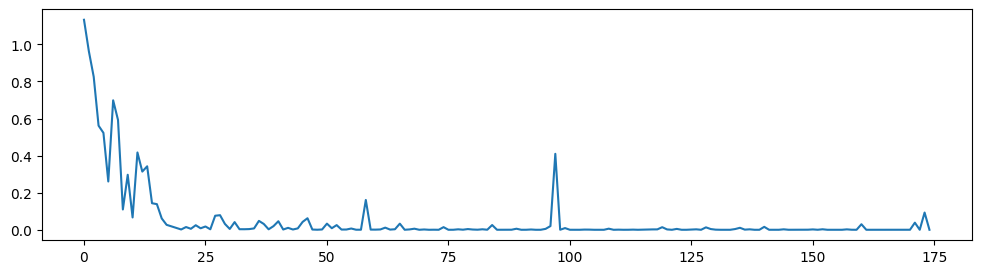

In [15]:
loss_history = trainer.loss_history

plt.figure(figsize=(12,3))
plt.plot(loss_history)
plt.show()

In [16]:
o

tensor([[[-1.4409, -5.8996,  2.4851],
         [-7.4817, -4.8466,  9.3178]]], grad_fn=<ViewBackward0>)

In [17]:
o.view(-1,vocab_size)

tensor([[-1.4409, -5.8996,  2.4851],
        [-7.4817, -4.8466,  9.3178]], grad_fn=<ViewBackward0>)